<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Binaria_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Binarizado2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            label = linha[1]
            if label == 'NC':
              y_true.append(1)
            else:
              y_true.append(0)

            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)

            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            else:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



## Implementação



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['C', 'NC'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['C', 'NC'], 
                                                 batch_size=bSize)

Found 4230 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize



---



### 1 tentativa Accuracy: 83.02%


**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_1'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [15]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6949 - acc: 0.4813 - val_loss: 0.6862 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.68623, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.6963 - acc: 0.5187 - val_loss: 0.6920 - val_acc: 0.5312

Epoch 00002: val_loss did not improve from 0.68623
Epoch 3/50
 - 1s - loss: 0.6811 - acc: 0.5625 - val_loss: 0.7284 - val_acc: 0.5312

Epoch 00003: val_loss did not improve from 0.68623
Epoch 4/50
 - 1s - loss: 0.7277 - acc: 0.4937 - val_loss: 0.6904 - val_acc: 0.5469

Epoch 00004: val_loss did not improve from 0.68623
Epoch 5/50
 - 1s - loss: 0.6948 - acc: 0.5125 - val_loss: 0.7025 - val_acc: 0.5156

Epoch 00005: val_loss did not improve from 0.68623
Epoch 6/50
 - 1s - loss: 0.6707 - acc: 0.5750 - val_loss: 0.8698 - val_acc: 0.4375

Epoch 00006: val_loss did not improve from 0.68623
Epoch 7/50
 - 1s - loss: 0.7390 - acc: 0.5062 - val_loss: 0.6936 - val_acc: 0.5000

Epoch 00007: val_loss did not improv

In [0]:
model.load_weights('drive/My Drive/Resultado/weights_architecture_1.hdf5')

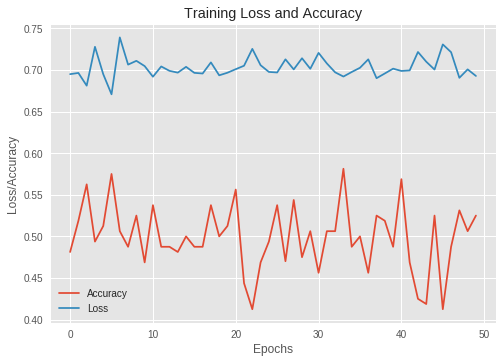

In [17]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [18]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [19]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.02%




---



### 2 tentativa Accuracy: 80.87%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_2'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [24]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6927 - acc: 0.5484 - val_loss: 0.6935 - val_acc: 0.4844

Epoch 00001: val_loss improved from inf to 0.69350, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6938 - acc: 0.4750 - val_loss: 0.6928 - val_acc: 0.5156

Epoch 00002: val_loss improved from 0.69350 to 0.69279, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6940 - acc: 0.4562 - val_loss: 0.6929 - val_acc: 0.5781

Epoch 00003: val_loss did not improve from 0.69279
Epoch 4/50
 - 1s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6921 - val_acc: 0.5625

Epoch 00004: val_loss improved from 0.69279 to 0.69213, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 5/50
 - 1s - loss: 0.6931 - acc: 0.4500 - val_loss: 0.6929 - val_acc: 0.5156

Epoch 00005: val_loss did not improve from 0.69213
Epoch 6/50
 - 1s - loss: 0.6928 - acc: 0.5250 - val_loss: 0.6928 - val_acc: 0.5781

Epoch 00006: val_loss d

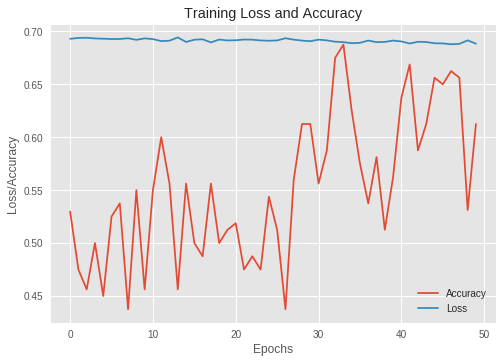

In [25]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [26]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [27]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 80.87%


### 3 tentativa Accuracy: 82.78%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_3'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [32]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 2.0575 - acc: 0.5219 - val_loss: 0.6510 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.65102, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 1.7303 - acc: 0.5344 - val_loss: 0.5918 - val_acc: 0.7656

Epoch 00002: val_loss improved from 0.65102 to 0.59183, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 3/50
 - 1s - loss: 1.1543 - acc: 0.5781 - val_loss: 0.5345 - val_acc: 0.7734

Epoch 00003: val_loss improved from 0.59183 to 0.53446, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 4/50
 - 1s - loss: 0.8532 - acc: 0.6710 - val_loss: 0.5488 - val_acc: 0.7812

Epoch 00004: val_loss did not improve from 0.53446
Epoch 5/50
 - 1s - loss: 0.7388 - acc: 0.6781 - val_loss: 0.5677 - val_acc: 0.7734

Epoch 00005: val_loss did not improve from 0.53446
Epoch 6/50
 - 1s - loss: 0.5005 - acc: 0.8063 - val_loss: 0.3702 - val_acc: 0.8594

Epoch 00006: val_loss i

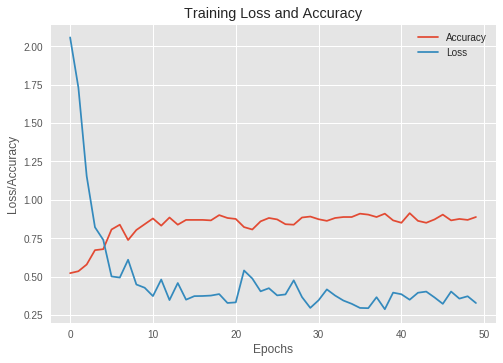

In [33]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [34]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [35]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 82.78%


### 4 tentativa  Accuracy: 83.02%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_4'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [40]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5351 - acc: 0.7625 - val_loss: 1.9134 - val_acc: 0.6328

Epoch 00001: val_loss improved from inf to 1.91339, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.4383 - acc: 0.8156 - val_loss: 1.1704 - val_acc: 0.6953

Epoch 00002: val_loss improved from 1.91339 to 1.17036, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 3/50
 - 1s - loss: 0.2808 - acc: 0.9250 - val_loss: 1.0352 - val_acc: 0.6875

Epoch 00003: val_loss improved from 1.17036 to 1.03518, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 4/50
 - 1s - loss: 0.2945 - acc: 0.9094 - val_loss: 0.5649 - val_acc: 0.7969

Epoch 00004: val_loss improved from 1.03518 to 0.56488, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 5/50
 - 1s - loss: 0.3466 - acc: 0.8969 - val_loss: 0.6418 - val_acc: 0.8047

Epoch 00005: val_loss did not improve from 0.56488
Epoch 6/50
 - 1s - loss: 0.2650 -

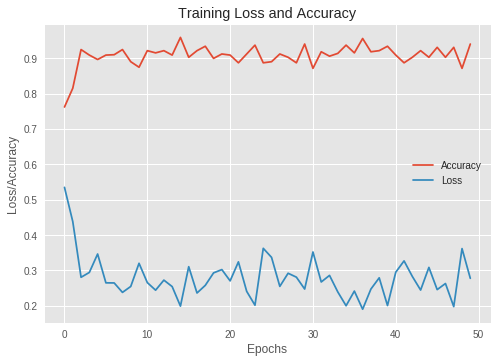

In [41]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [42]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [43]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.02%


### 5 tentativa Accuracy: 83.73%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_5'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [48]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 3.9349 - acc: 0.4688 - val_loss: 1.5235 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.52346, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 1.7098 - acc: 0.5625 - val_loss: 0.6115 - val_acc: 0.6797

Epoch 00002: val_loss improved from 1.52346 to 0.61153, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 1.8008 - acc: 0.5344 - val_loss: 1.0614 - val_acc: 0.4922

Epoch 00003: val_loss did not improve from 0.61153
Epoch 4/50
 - 1s - loss: 1.2126 - acc: 0.6094 - val_loss: 0.6276 - val_acc: 0.7109

Epoch 00004: val_loss did not improve from 0.61153
Epoch 5/50
 - 0s - loss: 0.7302 - acc: 0.6594 - val_loss: 0.7085 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.61153
Epoch 6/50
 - 1s - loss: 0.7225 - acc: 0.7000 - val_loss: 0.6077 - val_acc: 0.6875

Epoch 00006: val_loss improved from 0.61153 to 0.60770, saving model to drive/My Drive/Resultado/

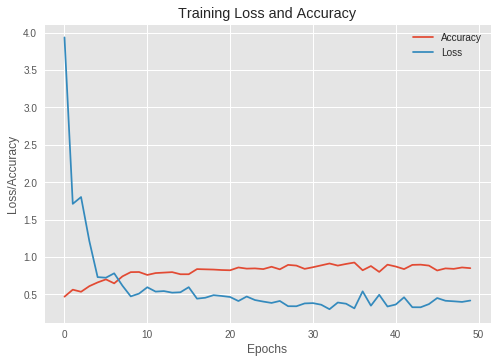

In [49]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [50]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [51]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.73%


### 6 tentativa Accuracy: 83.02%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_6'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [56]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5375 - acc: 0.7625 - val_loss: 0.8103 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.81034, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4498 - acc: 0.8344 - val_loss: 0.7153 - val_acc: 0.7031

Epoch 00002: val_loss improved from 0.81034 to 0.71527, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3966 - acc: 0.8594 - val_loss: 0.3156 - val_acc: 0.9141

Epoch 00003: val_loss improved from 0.71527 to 0.31555, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 4/50
 - 0s - loss: 0.3327 - acc: 0.9094 - val_loss: 0.4104 - val_acc: 0.8281

Epoch 00004: val_loss did not improve from 0.31555
Epoch 5/50
 - 0s - loss: 0.3436 - acc: 0.8875 - val_loss: 0.4606 - val_acc: 0.7841

Epoch 00005: val_loss did not improve from 0.31555
Epoch 6/50
 - 0s - loss: 0.2944 - acc: 0.9281 - val_loss: 0.5463 - val_acc: 0.8125

Epoch 00006: val_loss d

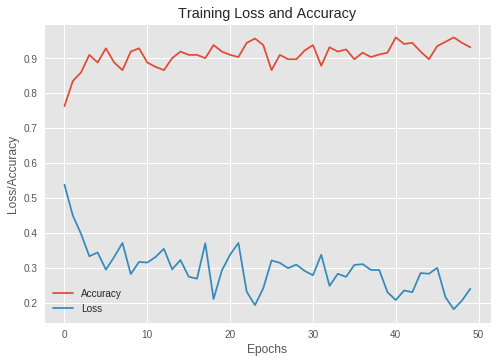

In [57]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [58]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [59]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.02%


### 7 tentativa Accuracy: 83.02%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_7'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [64]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5706 - acc: 0.7500 - val_loss: 1.0763 - val_acc: 0.6797

Epoch 00001: val_loss improved from inf to 1.07627, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4230 - acc: 0.8406 - val_loss: 1.8755 - val_acc: 0.6016

Epoch 00002: val_loss did not improve from 1.07627
Epoch 3/50
 - 1s - loss: 0.3684 - acc: 0.8719 - val_loss: 0.4494 - val_acc: 0.8409

Epoch 00003: val_loss improved from 1.07627 to 0.44935, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 4/50
 - 1s - loss: 0.3549 - acc: 0.8906 - val_loss: 0.3305 - val_acc: 0.8984

Epoch 00004: val_loss improved from 0.44935 to 0.33052, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 5/50
 - 1s - loss: 0.4211 - acc: 0.8500 - val_loss: 0.4817 - val_acc: 0.8438

Epoch 00005: val_loss did not improve from 0.33052
Epoch 6/50
 - 1s - loss: 0.3239 - acc: 0.8875 - val_loss: 0.8946 - val_acc: 0.7422

Epoch 00006: val_loss d

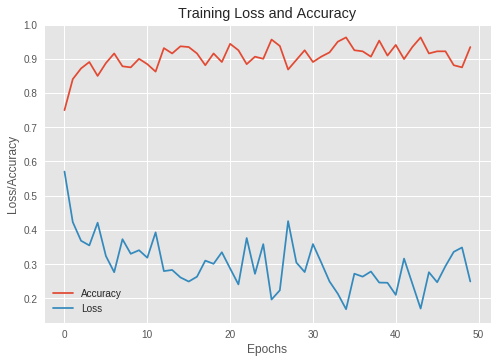

In [65]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [66]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [67]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.02%


### 8 tentativa Accuracy: 83.25%  

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_8'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [72]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 2.8900 - acc: 0.5469 - val_loss: 0.7068 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.70678, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.7621 - acc: 0.5875 - val_loss: 1.1158 - val_acc: 0.6406

Epoch 00002: val_loss did not improve from 0.70678
Epoch 3/50
 - 1s - loss: 1.1496 - acc: 0.6031 - val_loss: 0.9372 - val_acc: 0.5938

Epoch 00003: val_loss did not improve from 0.70678
Epoch 4/50
 - 1s - loss: 0.7862 - acc: 0.7000 - val_loss: 0.6493 - val_acc: 0.7031

Epoch 00004: val_loss improved from 0.70678 to 0.64933, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 5/50
 - 1s - loss: 0.8598 - acc: 0.6594 - val_loss: 0.7645 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.64933
Epoch 6/50
 - 1s - loss: 0.6882 - acc: 0.7156 - val_loss: 0.4829 - val_acc: 0.8047

Epoch 00006: val_loss improved from 0.64933 to 0.48291, saving model to drive/My Drive/Resultado/

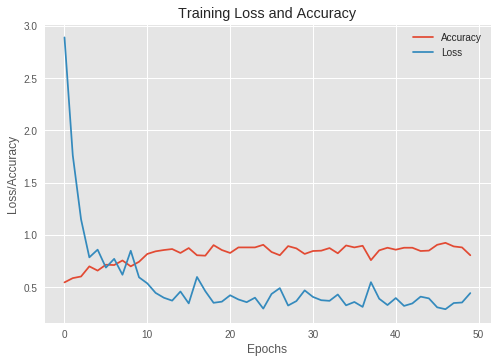

In [73]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [74]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [75]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.25%


### 9 tentativa Accuracy: 82.83%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_9'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [80]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 6.6776 - acc: 0.4750 - val_loss: 4.7773 - val_acc: 0.4531

Epoch 00001: val_loss improved from inf to 4.77731, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 5.3851 - acc: 0.5031 - val_loss: 1.9973 - val_acc: 0.5781

Epoch 00002: val_loss improved from 4.77731 to 1.99732, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 3/50
 - 0s - loss: 2.0676 - acc: 0.5781 - val_loss: 0.9574 - val_acc: 0.3750

Epoch 00003: val_loss improved from 1.99732 to 0.95745, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 4/50
 - 0s - loss: 0.9300 - acc: 0.5969 - val_loss: 0.8145 - val_acc: 0.5625

Epoch 00004: val_loss improved from 0.95745 to 0.81450, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 0.6813 - acc: 0.6937 - val_loss: 0.6595 - val_acc: 0.7656

Epoch 00005: val_loss improved from 0.81450 to 0.65954, saving model to drive/My Dri

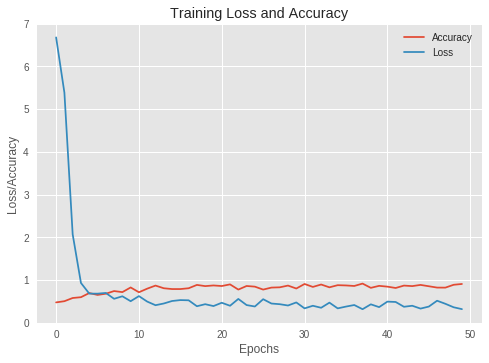

In [81]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [82]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [83]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 82.83%


### 10 tentativa Accuracy: 83.02%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_10'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [88]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.4607 - acc: 0.5406 - val_loss: 0.9277 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 0.92768, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.0576 - acc: 0.6312 - val_loss: 0.7264 - val_acc: 0.5938

Epoch 00002: val_loss improved from 0.92768 to 0.72640, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.9568 - acc: 0.6219 - val_loss: 0.6704 - val_acc: 0.6484

Epoch 00003: val_loss improved from 0.72640 to 0.67044, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.8496 - acc: 0.6844 - val_loss: 0.4924 - val_acc: 0.8281

Epoch 00004: val_loss improved from 0.67044 to 0.49244, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.6853 - acc: 0.7188 - val_loss: 0.9348 - val_acc: 0.6094

Epoch 00005: val_loss did not improve from 0.49244
Epoch 6/50
 - 1s - loss: 0.68

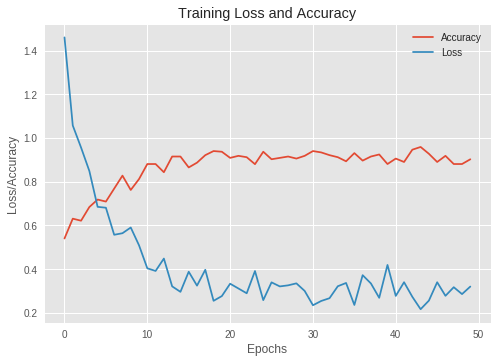

In [89]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [90]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [91]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 83.02%


### 11 tentativa Accuracy: 64.59%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_11'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [96]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.3217 - acc: 0.4937 - val_loss: 1.3679 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 1.36794, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.6049 - acc: 0.5406 - val_loss: 0.8884 - val_acc: 0.4766

Epoch 00002: val_loss improved from 1.36794 to 0.88836, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 1.2529 - acc: 0.5469 - val_loss: 0.6189 - val_acc: 0.7266

Epoch 00003: val_loss improved from 0.88836 to 0.61893, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 1.1070 - acc: 0.5625 - val_loss: 0.7349 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 0.61893
Epoch 5/50
 - 1s - loss: 0.9283 - acc: 0.5906 - val_loss: 0.7582 - val_acc: 0.5234

Epoch 00005: val_loss did not improve from 0.61893
Epoch 6/50
 - 1s - loss: 1.1251 - acc: 0.5656 - val_loss: 0.7527 - val_acc: 0.5938

Epoch 00006: val_los

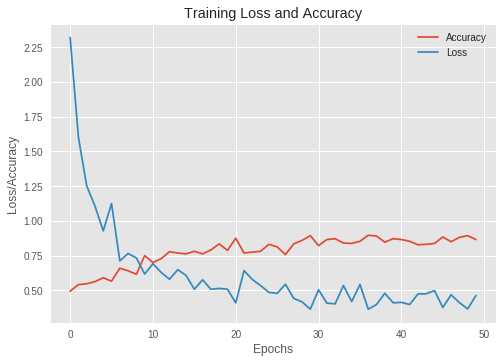

In [97]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [98]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [99]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 64.59%


### 12 tentativa  Accuracy: 82.68%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_12'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [104]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.2936 - acc: 0.5031 - val_loss: 0.7501 - val_acc: 0.5391

Epoch 00001: val_loss improved from inf to 0.75010, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.4131 - acc: 0.5125 - val_loss: 0.6710 - val_acc: 0.5781

Epoch 00002: val_loss improved from 0.75010 to 0.67098, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.3399 - acc: 0.5516 - val_loss: 0.6480 - val_acc: 0.6094

Epoch 00003: val_loss improved from 0.67098 to 0.64797, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 1.0420 - acc: 0.5281 - val_loss: 0.7061 - val_acc: 0.5156

Epoch 00004: val_loss did not improve from 0.64797
Epoch 5/50
 - 1s - loss: 0.9026 - acc: 0.5594 - val_loss: 0.5924 - val_acc: 0.8125

Epoch 00005: val_loss improved from 0.64797 to 0.59235, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 6/50
 - 1s - loss: 0.84

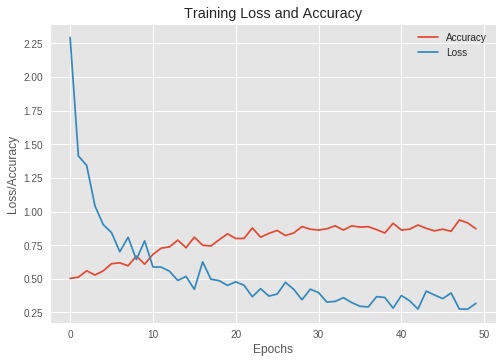

In [105]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [106]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [107]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 82.68%
